<a href="https://colab.research.google.com/github/btg1631/study_data_analytics/blob/main/docs/quests/EDAs/EDA_LetalCarOfContractType.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 한글 폰트 설치 및 시각화

In [1]:
# 한글 폰트 설치
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 설치 후 colab 경우 Runtime > Restart session 필요

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (21.6 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 121730 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

mpl.rc('font', family='NanumBarunGothic') # 혹은 다른 설치한 Nanum 폰트 사용

## EDA 각 과정에서 insight 도출
- 제안 3: 연체 위험도 예측
 + 문제 정의: 고객의 연체 기록, 신용 등급, 계약 유형 등을 사용하여 미래의 연체 가능성을 예측합니다.
 + 배경: 연체 위험도가 높은 고객을 사전에 식별하여, 적절한 조치를 취함으로써 재정적 손실을 최소화할 수 있습니다

In [2]:
import pandas as pd
df_LCOCT = pd.read_csv('LetalCarOfContractType.csv')
df_LCOCT.dropna(inplace=True)
df_LCOCT[:2]

,id,type_of_contract,type_of_contract2,channel,datetime,Term,payment_type,product,amount,state,overdue_count,overdue,credit rating,bank,cancellation,age,Mileage
0,66758234,렌탈,Normal,서비스 방문,2019-10-20,60,CMS,K1,96900,계약확정,0,없음,9.0,새마을금고,정상,43.0,1862.0
1,66755948,렌탈,Extension_Rental,서비스 방문,2019-10-20,60,카드이체,K1,102900,계약확정,0,없음,2.0,현대카드,정상,62.0,2532.0


In [8]:
df_LCOCT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40480 entries, 0 to 51303
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 40480 non-null  int64  
 1   type_of_contract   40480 non-null  object 
 2   type_of_contract2  40480 non-null  object 
 3   channel            40480 non-null  object 
 4   datetime           40480 non-null  object 
 5   Term               40480 non-null  int64  
 6   payment_type       40480 non-null  object 
 7   product            40480 non-null  object 
 8   amount             40480 non-null  int64  
 9   state              40480 non-null  object 
 10  overdue_count      40480 non-null  int64  
 11  overdue            40480 non-null  object 
 12  credit rating      40480 non-null  float64
 13  bank               40480 non-null  object 
 14  cancellation       40480 non-null  object 
 15  age                40480 non-null  float64
 16  Mileage            404

### 기술 데이터 분석(DDA)

#### 연체 기록 분포 확인

In [9]:
# 연체 기록 분포 확인
df_LCOCT['overdue'].value_counts()

없음    39019
있음     1461
Name: overdue, dtype: int64

In [4]:
# 연체 기록이 있는 고객만 선별
df_is_overdue = df_LCOCT.query('overdue == "있음"')
# 연체 횟수 확인
df_is_overdue['overdue_count'].describe()

# 연체 기록이 있는 고객 중 연체 횟수 중앙값은 2 이다. 연체 기록이 있는 고객 중 연체 기록이 중앙값보다 높은 3번 이상인 고객이 연체 위험도가 높다고 판단.
# 인사이트 : 연체 기록이 일정 수 이상이 된 고객은 블랙리스트에 등록한다.

count    1461.000000
mean        4.060917
std         4.097074
min         1.000000
25%         1.000000
50%         2.000000
75%         7.000000
max        15.000000
Name: overdue_count, dtype: float64

#### 신용 등급 분포 확인

In [5]:
# 신용 등급 분포(범주형) 확인
df_LCOCT['credit rating'].value_counts()

# 대부분의 고객들이 1~5등급 범위의 신용등급을 가지고 있다. 일반적으로 신용등급이 낮을수록(숫자가 클수록) 연체 위험도가 높아질 가능성이 있음.

1.0     10245
2.0      7811
4.0      5137
3.0      4777
5.0      4116
6.0      3624
7.0      2589
8.0      1466
9.0       610
0.0        60
10.0       45
Name: credit rating, dtype: int64

In [10]:
# 연체 기록이 있는 고객들의 신용 등급 분포(범주형) 확인
df_is_overdue['credit rating'].value_counts()

# 대부분의 고객들이 6~8등급 범위의 신용등급을 가지고 있다. 신용등급 6~8등급 사이의 고객들이 연체 위험도가 높다고 판단.
# 인사이트 : 신용등급에 제한을 둬 대여 조건을 강화한다.

7.0     353
8.0     302
6.0     249
5.0     149
9.0     135
4.0     114
3.0      60
2.0      47
1.0      40
10.0      9
0.0       3
Name: credit rating, dtype: int64

#### 지불 방식 분포 확인

In [14]:
# 지불 방식 분포 확인
df_LCOCT['payment_type'].value_counts()

# 약 1.852배 차이

CMS     26274
카드이체    14206
Name: payment_type, dtype: int64

In [13]:
# 연체 기록이 있는 고객들의 지불 방식 분포 확인
df_is_overdue['payment_type'].value_counts()

# CMS가 카드이체의 약 6.98배이므로 CMS를 사용한 고객이 연체 위험도가 높다고 판단.
# 인사이트 :

CMS     1278
카드이체     183
Name: payment_type, dtype: int64

### EDA
- 추가 확인 후 인사이트 재조정

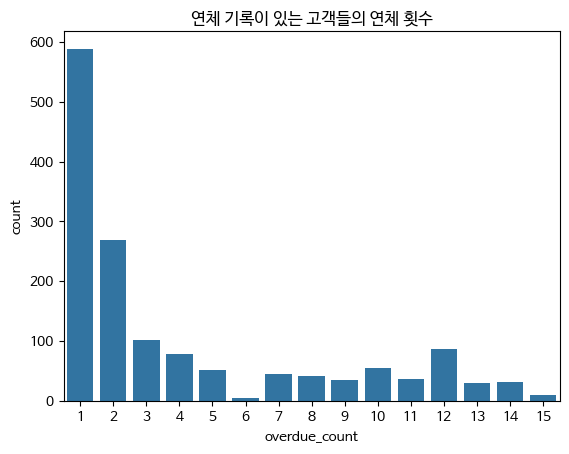

In [16]:
sns.countplot(data=df_is_overdue, x='overdue_count')
plt.title("연체 기록이 있는 고객들의 연체 횟수")
plt.show()

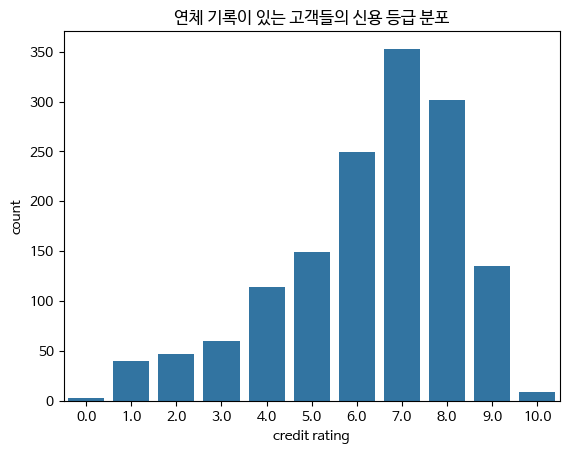

In [17]:
sns.countplot(data=df_is_overdue, x='credit rating')
plt.title("연체 기록이 있는 고객들의 신용 등급 분포")
plt.show()

## 보고용 insight 작성

- 연체 기록 분포 확인
 + 연체 기록이 있는 고객 중에서 분석했을 때, 연체 횟수가 중앙(1 ~ 7)에 분포해 있음. 연체 기록이 있는 고객 중 연체 기록이 중앙값보다 높은 3번 이상인 고객이 연체 위험도가 높다고 판단.
 + 전략 제안 : 연체 기록이 일정 수 이상이 된 고객은 블랙리스트에 등록한다.

- 신용 등급 분포 확인
 + 분석 결과 : 대부분의 고객들이 6-8등급 범위의 신용등급을 가지고 있음. 신용등급 6-8등급 사이의 고객들이 연체 위험도가 높다고 판단.
 + 전략 제안 : 신용등급에 제한을 둬 대여 조건을 강화한다.

- 지불 방식 분포 확인
 + 분석 결과 : CMS가 카드이체의 약 7배이므로 CMS를 사용한 고객이 연체 위험도가 높다고 판단.
 + 전략 제안 : 어떠카지
